In [3]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-10-01'

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO redo this with only TEST_TICKER

value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)


df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (19981, 8)


In [4]:
from stable_baselines3 import PPO, A2C

# from .online import CRPModel, BAHModel, BCRPModel, OLMARModel, RMRModel, BNNModel

from stable_baselines3.common.callbacks import BaseCallback

MODELS = {
    "ppo": PPO, 
    "a2c": A2C, 
    # "crp": CRPModel, 
    # "bah": BAHModel, 
    # "bcrp": BCRPModel, 
    # "olmar": OLMARModel,
    # "rmr": RMRModel,
    # "bnn": BNNModel
}

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])

            state = self.locals['obs']
            action = self.locals['actions']
            print(f"State: {state}, Action: {action}")
            return True

        except BaseException as error:
            try:
                self.logger.record(key="train/reward", value=self.locals["reward"][0])

            except BaseException as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
        return True

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # Default to use the MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, tb_log_name=None, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes,
            callback=TensorboardCallback(),
            tb_log_name=tb_log_name,
            progress_bar=True
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True, verbose=False):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)

            print(action)

            if(verbose):
                print("Step: ", str(i))
                print("Observations: ")
                print(test_obs)
                print("Actions: ")
                print(action)

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

# Portfolio Optimization Algorithm

In [5]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.32787728 0.31163057 0.29665379 0.30407942 0.27208839 0.33502458
 0.2389178  0.2347346  0.26517455 0.25241881 0.28541712 0.29752426
 0.2868725  0.38549309 0.50927153 0.36336901 0.33976194 0.38268683
 0.56462833 0.36256319 0.27053448 0.2664564  0.28058908 0.25877189
 0.24241002 0.23480991 0.22368841 0.2851322  0.30962323 0.27044536
 0.19620754 0.19197132 0.2183674  0.25973618 0.28606385 0.28244392
 0.44291309 0.28860998 0.29828238 0.26193808 0.25017204 0.2406126
 0.26276273 0.30255689 0.41153615 0.28698045 0.3305574  0.30428684
 0.34119535 0.29171686 0.3210124  0.23727697 0.38757292 0.3006509
 0.25584293 0.30771536 0.28282738 0.25274955 0.28358205 0.31564401
 0.29067789 0.32336304 0.24711725 0.23995363 0.23033081 0.27946162
 0.2434879  0.24028971 0.22670

In [6]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_17464\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [7]:
EIIE_results = {
    "20212024": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["20212024"]["value"] = environment._asset_memory["final"]
EIIE_results["20212024"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["20212024"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["20212024"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1205316.75
Final accumulative portfolio value: 1.20531675
Maximum DrawDown: -0.20033205597581782
Sharpe ratio: 0.5438801305912347


In [8]:
print(df_opt)

     opt_net_worth       Date
0     1.000000e+06 2022-02-07
1     1.008304e+06 2022-02-08
2     1.016470e+06 2022-02-09
3     1.003896e+06 2022-02-10
4     9.908632e+05 2022-02-11
..             ...        ...
660   1.197892e+06 2024-09-24
661   1.191708e+06 2024-09-25
662   1.199446e+06 2024-09-26
663   1.206157e+06 2024-09-27
664   1.205317e+06 2024-09-30

[665 rows x 2 columns]


In [9]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2022-02-07 00:00:00
2024-09-30 00:00:00


# PPO On portfolio Opt

In [10]:

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df


environment_ppo = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [11]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_dji_2021_1110") 

# trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_20092021_11_1") 

In [12]:
# from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "20212024": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["20212024"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["20212024"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["20212024"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt.loc[len(df_ppo_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[[1.         0.         1.         0.         1.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.40800726 1.         1.         0.         0.4495221
  0.         0.         1.         0.         0.         0.4551956
  1.         0.2506575  1.         1.         1.         1.        ]]
[[1.         0.         1.         0.         1.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.40802917 1.         1.         0.         0.44951376
  0.         0.         1.         0.         0.         0.45518225
  1.         0.25064725 1.         1.         1.         1.        ]]
[[1.         0.         1.         0.         1.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.40805316 1.         1.         0.         0.4495136
  0.         0.         1.         0.         0.         0.45515627
  1.         0.2506349  1.         1.         1.         1.        ]]
[[1.         0.         1

In [13]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2022-02-07 00:00:00')

In [14]:
df_opt.loc[0,'Date']

Timestamp('2022-02-07 00:00:00')

# Porfolio Baselines

In [15]:
# CRP 

CRP_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_crp = DRLStableAgent(env = environment_ppo)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_ppo)
CRP_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
CRP_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["20212024"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["20212024"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

NotImplementedError: The model requested was not implemented.

In [ ]:
# BAH

BAH_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_bah = DRLStableAgent(env = environment_ppo)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_ppo)
BAH_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BAH_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["20212024"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["20212024"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1225164.125
Final accumulative portfolio value: 1.225164125
Maximum DrawDown: -0.19904617983087058
Sharpe ratio: 0.6036936600845776
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2022-02-07
1         1.008304e+06 2022-02-08
2         1.016426e+06 2022-02-09
3         1.003803e+06 2022-02-10
4         9.906989e+05 2022-02-11
..                 ...        ...
660       1.220727e+06 2024-09-24
661       1.213844e+06 2024-09-25
662       1.220156e+06 2024-09-26
663       1.224321e+06 2024-09-27
664       1.225164e+06 2024-09-30

[665 rows x 2 columns]


In [ ]:
# OLMAR

OLMAR_results = {
    "20212024": {},
}

# OLMAR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }


environment_ppo.reset()
agent_olmar = DRLStableAgent(env = environment_ppo)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_ppo)
OLMAR_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
OLMAR_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["20212024"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["20212024"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 687804.625
Final accumulative portfolio value: 0.687804625
Maximum DrawDown: -0.4068708949472202
Sharpe ratio: -0.2425343770936351
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2022-02-07
1           1.008304e+06 2022-02-08
2           9.904118e+05 2022-02-09
3           9.554619e+05 2022-02-10
4           9.366943e+05 2022-02-11
..                   ...        ...
660         6.705936e+05 2024-09-24
661         6.615247e+05 2024-09-25
662         6.733701e+05 2024-09-26
663         6.809036e+05 2024-09-27
664         6.878046e+05 2024-09-30

[665 rows x 2 columns]


In [ ]:
# RMR

RMR_results = {
    "20212024": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_rmr = DRLStableAgent(env = environment_ppo)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_ppo)
RMR_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
RMR_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["20212024"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["20212024"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 854505.6875
Final accumulative portfolio value: 0.8545056875
Maximum DrawDown: -0.36428323713386224
Sharpe ratio: -0.1284250522691466
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2022-02-07
1         1.008304e+06 2022-02-08
2         9.904118e+05 2022-02-09
3         9.554619e+05 2022-02-10
4         9.366943e+05 2022-02-11
..                 ...        ...
660       8.431668e+05 2024-09-24
661       8.263878e+05 2024-09-25
662       8.541561e+05 2024-09-26
663       8.544183e+05 2024-09-27
664       8.545057e+05 2024-09-30

[665 rows x 2 columns]


In [ ]:
# BNN

BNN_results = {
    "20212024": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_bnn = DRLStableAgent(env = environment_ppo)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_ppo)
BNN_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BNN_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["20212024"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["20212024"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 846238.875
Final accumulative portfolio value: 0.846238875
Maximum DrawDown: -0.37051920681452843
Sharpe ratio: -0.1427281258439645
hit end!
     bnn_opt_net_worth       Date
0         1000000.0000 2022-02-07
1         1000000.0000 2022-02-08
2         1000000.0000 2022-02-09
3         1000000.0000 2022-02-10
4         1000000.0000 2022-02-11
..                 ...        ...
660        835009.5625 2024-09-24
661        818392.8750 2024-09-25
662        845892.6250 2024-09-26
663        846152.3125 2024-09-27
664        846238.8750 2024-09-30

[665 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [ ]:
# bcrp

BCRP_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_bcrp= DRLStableAgent(env = environment_ppo)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_ppo)
BCRP_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BCRP_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["20212024"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["20212024"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1582831.625
Final accumulative portfolio value: 1.582831625
Maximum DrawDown: -0.16403403358679858
Sharpe ratio: 0.9714693681967185
hit end!
     bcrp_opt_net_worth       Date
0           1000000.000 2022-02-07
1            991364.000 2022-02-08
2            986465.625 2022-02-09
3            986852.375 2022-02-10
4            987883.625 2022-02-11
..                  ...        ...
660         1602345.375 2024-09-24
661         1599139.625 2024-09-25
662         1576280.750 2024-09-26
663         1584643.750 2024-09-27
664         1582831.625 2024-09-30

[665 rows x 2 columns]


# Stock environment optimization algorithm

In [ ]:
# from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [ ]:
# from stable_baselines3 import PPO, TD3, A2C
# from finrl.config import TRAINED_MODEL_DIR


# # Load the trained models
# trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

# trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") 

# trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") 

In [ ]:
# # Test out of sample performance

# stock_dimension = len(test.tic.unique())
# state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
# print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

In [ ]:
# buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
# num_stock_shares = [0] * stock_dimension

# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": INITIAL_CASH,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

In [ ]:
# e_trade_gym_ppo = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_ppo, df_actions_ppo = StockDRLAgent.DRL_prediction(
#     model=trained_ppo, 
#     environment = e_trade_gym_ppo,
#     deterministic=True)

In [ ]:
# df_account_value_ppo.rename(columns={'date': 'Date', 'account_value' : "ppo_value"}, inplace=True)
# df_account_value_ppo

In [ ]:
# e_trade_gym_td3 = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_td3, df_actions_td3 = StockDRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym_td3)

In [ ]:
# df_account_value_td3.rename(columns={'date': 'Date', 'account_value' : "td3_value"}, inplace=True)
# df_account_value_td3

In [ ]:

# e_trade_gym_a2c = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_a2c, df_actions_a2c = StockDRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym_a2c)

# df_account_value_a2c.rename(columns={'date': 'Date', 'account_value' : "a2c_value"}, inplace=True)
# df_account_value_a2c

In [ ]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (664, 8)
Annual return          0.073608
Cumulative returns     0.205803
Annual volatility      0.149795
Sharpe ratio           0.549792
Calmar ratio           0.373846
Stability              0.684190
Max drawdown          -0.196895
Omega ratio            1.098699
Sortino ratio          0.782455
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.038785
Daily value at risk   -0.018546
dtype: float64
df_dji:            date           dji
0   2022-02-07  1.000000e+06
1   2022-02-08  1.010591e+06
2   2022-02-09  1.019291e+06
3   2022-02-10  1.004288e+06
4   2022-02-11  9.899385e+05
..         ...           ...
660 2024-09-24  1.202817e+06
661 2024-09-25  1.194454e+06
662 2024-09-26  1.201874e+06
663 2024-09-27  1.205803e+06
664 2024-09-30           NaN

[665 rows x 2 columns]
df_dji:                       dji
date                    
2022-02-07  1.000000e+06
2022-02-08  1.010591e+06
2022-02-09  1.019291e+06
2022-02-10  1.004288e+06

# Compare all results

In [ ]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')




print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2022-02-07  1.000000e+06
2022-02-08  1.010591e+06
2022-02-09  1.019291e+06
2022-02-10  1.004288e+06
2022-02-11  9.899385e+05
...                  ...
2024-09-24  1.202817e+06
2024-09-25  1.194454e+06
2024-09-26  1.201874e+06
2024-09-27  1.205803e+06
2024-09-30           NaN

[665 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2022-02-07         1000000.000       1.000000e+06   
1         1.008304e+06 2022-02-08          991364.000       1.008304e+06   
2         1.016470e+06 2022-02-09          986465.625       1.016426e+06   
3         1.003896e+06 2022-02-10          986852.375       1.003803e+06   
4         9.908630e+05 2022-02-11          987883.625       9.906989e+05   
..                 ...        ...                 ...                ...   
660       1.197895e+06 2024-09-24         1602345.375       1.220727e+06   
661       1.191710e+06 2024-09-25         1

# Baseline CRP in the environment

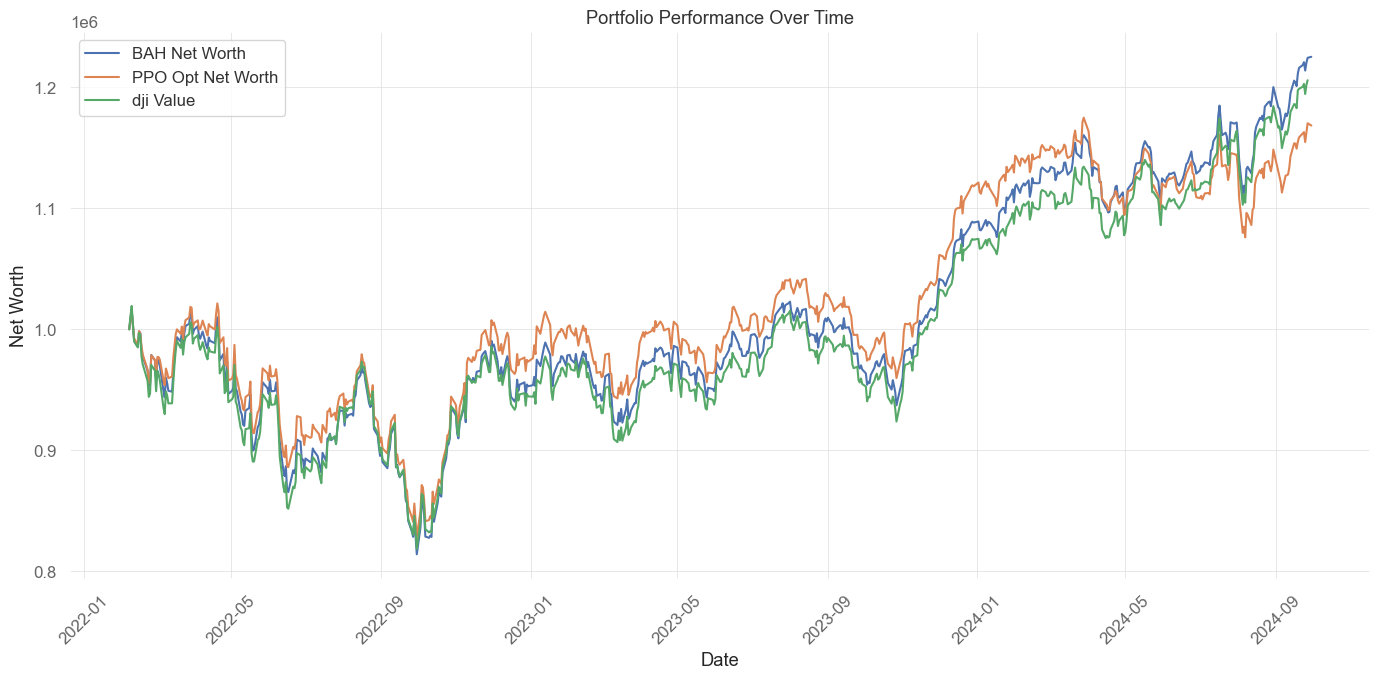

In [ ]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

# Plot the DataFrame
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['bcrp_opt_net_worth'], label='BCRP Net Worth')
# plt.plot(merged_df['Date'], merged_df['CRP_net_worth'], label='CRP Net Worth')# CRP and Opt net worth are basically on the same line
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth')
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth')
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth')
# plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth')
# plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth')


# plt.plot(merged_df['Date'], merged_df['opt_net_worth'], label='Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Opt Net Worth')
# plt.plot(merged_df['Date'], merged_df['ppo_value'], label='PPO Value')
# plt.plot(merged_df['Date'], merged_df['td3_value'], label='TD3 Value')
# plt.plot(merged_df['Date'], merged_df['a2c_value'], label='A2C Value')
plt.plot(merged_df['Date'], merged_df['dji'], label='dji Value')
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 1225164.125,
 'BCRP OPT': 1582831.625,
 'BNN': 846238.875,
 'CRP': 1205319.75,
 'OLMAR': 687804.625,
 'PPO': 1168414.75,
 'RMR': 854505.6875}


In [ ]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP OPT': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP OPT': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'BAH OPT': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO Opt': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH OPT': 0.4661908042227689,
 'BCRP OPT': 0.872172435774785,
 'BNN': -0.22605174108993517,
 'CRP OPT': 0.4120271457077683,
 'OLMAR': -0.30107160272200933,
 'PPO Opt': 0.3500714594532896,
 'RMR': -0.2119689300368504}


In [ ]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP Opt': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP Opt': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH Opt': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR Opt': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR Opt': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN Opt': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO Opt': max_drawdown(merged_df['ppo_opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH Opt': -0.19904617983087058,
 'BCRP Opt': -0.16403403358679858,
 'BNN Opt': -0.37051920681452843,
 'CRP Opt': -0.20033715931746177,
 'OLMAR Opt': -0.4068708949472202,
 'PPO Opt': -0.1890218311074756,
 'RMR Opt': -0.36428323713386224}


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df         F    PR(>F)
Portfolio  0.000002     1.0  0.023047  0.879358
Residual   0.106373  1326.0       NaN       NaN


In [ ]:
merged_df['ppo_opt_daily_return']

0           NaN
1      0.008778
2      0.006177
3     -0.011494
4     -0.010744
         ...   
660    0.000927
661   -0.007060
662    0.006691
663    0.006680
664   -0.001556
Name: ppo_opt_daily_return, Length: 665, dtype: float64

In [ ]:
from scipy import stats

df_ppo = merged_df['ppo_opt_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.008304
2      0.008055
3     -0.012419
4     -0.013054
5     -0.004998
         ...   
660    0.001924
661   -0.005639
662    0.005200
663    0.003414
664    0.000688
Name: BAH_opt_daily_return, Length: 664, dtype: float64
t-statistic: -0.15181256006737723
p-value: 0.879357869166209
